# Data Preparation

In [1]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv("C:/Program Files/Weka-3-8/data/projeantartica_f.csv")
features.head(5)

,year,month,day,ActualMax,AverageTemp,MaxAvTemp,MinAvTemp
0,1960,1,1,47.0,33.6,37.4,29.9
1,1960,2,1,49.0,35.0,38.5,31.5
2,1960,3,1,47.0,34.3,38.7,29.8
3,1960,4,1,37.0,28.4,32.1,24.7
4,1960,5,1,38.0,24.5,28.9,20.1


In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (644, 7)


## One-Hot Encoding

One hot encoding takes this:

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

and converts it into:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [3]:
# One-hot encode categorical features
features = pd.get_dummies(features)
features.head(5)

,year,month,day,ActualMax,AverageTemp,MaxAvTemp,MinAvTemp
0,1960,1,1,47.0,33.6,37.4,29.9
1,1960,2,1,49.0,35.0,38.5,31.5
2,1960,3,1,47.0,34.3,38.7,29.8
3,1960,4,1,37.0,28.4,32.1,24.7
4,1960,5,1,38.0,24.5,28.9,20.1


In [4]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (644, 7)


## Features and Labels

In [5]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['ActualMax'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('ActualMax', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

## Training and Testing Sets

In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [7]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (483, 6)
Training Labels Shape: (483,)
Testing Features Shape: (161, 6)
Testing Labels Shape: (161,)


## Establish Baseline

In [8]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('MaxAvTemp')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  11.48 degrees.


## Training the Forest

In [9]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 2000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

In [10]:
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

## Make Predictions on Test Data

In [11]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 2.08 degrees.


In [12]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 95.01 %.


## Visualizing a Single Decision Tree

In [13]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

![Decision Tree](tree.png)

In [14]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 18


Smaller tree for visualization.

In [15]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png')

![Small Decision Tree](small_tree.PNG)

### Annotated Version of Tree

![Annotated Decision Tree](small_tree_annotated.PNG)

## Variable Importances

In [16]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MaxAvTemp            Importance: 0.63
Variable: year                 Importance: 0.14
Variable: AverageTemp          Importance: 0.09
Variable: MinAvTemp            Importance: 0.09
Variable: month                Importance: 0.05
Variable: day                  Importance: 0.0


### Two Most Important Features

In [17]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('MaxAvTemp'), feature_list.index('AverageTemp')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 2.42 degrees.
Accuracy: 94.31 %.


## Visualizations

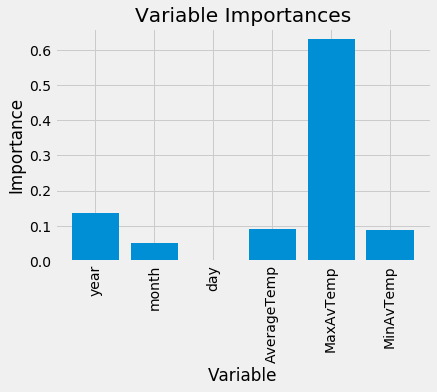

In [18]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [19]:
import datetime

# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'ActualMax': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 

C:\Users\asus\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


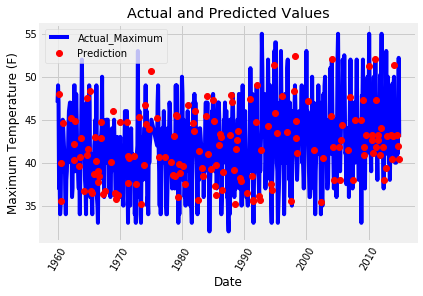

In [20]:
# Plot the actual values
plt.plot(true_data['date'], true_data['ActualMax'], 'b-', label = 'Actual_Maximum')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'Prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


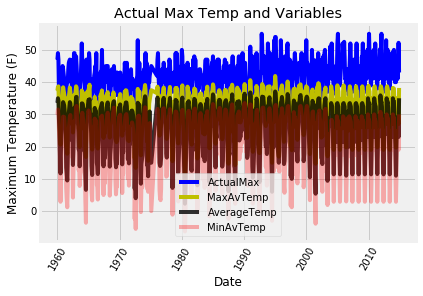

In [21]:
# Make the data accessible for plotting
true_data['MaxAvTemp'] = features[:, feature_list.index('MaxAvTemp')]
true_data['AverageTemp'] = features[:, feature_list.index('AverageTemp')]
true_data['MinAvTemp'] = features[:, feature_list.index('MinAvTemp')]
# Plot all the data as lines
plt.plot(true_data['date'], true_data['ActualMax'], 'b-', label  = 'ActualMax', alpha = 1.0)
plt.plot(true_data['date'], true_data['MaxAvTemp'], 'y-', label  = 'MaxAvTemp', alpha = 1.0)
plt.plot(true_data['date'], true_data['AverageTemp'], 'k-', label = 'AverageTemp', alpha = 0.8)
plt.plot(true_data['date'], true_data['MinAvTemp'], 'r-', label = 'MinAvTemp', alpha = 0.3)
# Formatting plot
plt.legend(); plt.xticks(rotation = '60');
# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');